# Utilize AutoSort in chronic recordings

In this tutorial, we demonstrate how to utilize a trained AutoSort model with late-stage recordings

For explanatory data analysis, we provide one days recording on 0415, which can be downloaded here.

In [1]:
from autosort_neuron import *
import warnings
warnings.filterwarnings("ignore")

/n/holystore01/LABS/jialiu_lab/Users/yichunhe/AutoSort/autosort_neuron/sorting.py:19: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


First, we set electrode probe of the new recording data.

In [2]:
positions=np.array([
                [150, 250], ### electrode 1
                [150,200], ### electrode 2
                [50, 0], ### electrode 3
                [50, 50],
                [50, 100], 
                [0, 100],
                [0, 50], 
                [0, 0],
                [650, 0], 
                [650, 50],
                [650, 100], 
                [600, 100],
                [600, 50], 
                [600, 0],
                [500, 200],
                [500, 250],
                [500, 300],
                [450, 300],
                [450, 250], 
                [450, 200],
                [350, 400], 
                [350, 450],
                [350, 500], 
                [300, 500],
                [300, 450], 
                [300, 400], 
                [200, 200],
                [200, 250],
                [200, 300],
                [150, 300]
                    ])
mesh_probe = create_mesh_probe(positions=positions,num_all_channels=positions.shape[0])

### raw data path
raw_data_path = './raw_data/'

### file folder name to read
date_id_all=['0415']

Load raw data recording from Intan system

In [3]:
for i in date_id_all:
    save_folder_name = i
    data_folder_all = f"./processed_data/Ephys_concat_{save_folder_name}/"
    if os.path.exists(data_folder_all) == False:
        _, _ = read_data_folder(
            data_folder_all,
            [i],
            raw_data_path,
            mesh_probe,
        )

Generate input of AutoSort.

In [4]:
save_pth = './AutoSort_data/'
day_pth = './processed_data/'
raw_data_path = './raw_data/'

freq_max=3000
freq_min=300

left_sample=10
right_sample=20


In [5]:
generate_autosort_input(date_id_all,
                            raw_data_path,
                            save_pth,
                            day_pth,
                            left_sample,
                            right_sample,
                            freq_min,
                            freq_max,
                            mesh_probe,
                            mode='test'
                            )

Apply AutoSort

In [7]:
### group ID of each electrode 1,2,3...
electrode_group=[1, 1, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
electrode_position=np.hstack([positions,np.array(electrode_group).reshape(-1,1)])

In [8]:
args=config()
args.day_id_str=['0305','0415'] ### all days
args.cluster_path='./AutoSort_data/' ### path of input data
args.set_time=0  ### set 0411 data as training data
args.test_time=[1] ### set 0420 data as testing data
args.group=np.arange(30)  ### all electrodes
args.samplepoints=left_sample+right_sample ### 30 points for each waveform
args.sensor_positions_all=electrode_position
args.mode='test'

In [12]:
run(args)

---------------------------------- SEED ALL ---------------------------------- 
                           Seed Num :   0                                
---------------------------------- SEED ALL ---------------------------------- 
pred_location (139245, 3)
pred_location (138641, 3)


100%|██████████| 271/271 [00:02<00:00, 98.88it/s] 


AutoSort results are saved in ./model_save/train_day0305_0/offline_results/[test date]/.

We read the results through `read_AutoSort_data` function

In [6]:
results_data_path =  f'./AutoSort_data/model_save/train_day0305_0/offline_result/0415/'
extremum_channels_ids_pth='./processed_data/Ephys_concat_0305_0310/mountainsort/extremum_channels_ids.csv'

(sorting,  
 trial_start, 
 trial_end,  
 cont_trigger_all_all,
 recording_cmr) = read_AutoSort_data('0415',
                                     day_pth,
                                     results_data_path, 
                                     save_pth=save_pth,
                                     extremum_channels_ids_pth=extremum_channels_ids_pth
                                     )  

0415 there are 7 trials at an interval of: 19403


Extract waveforms

In [8]:
mesh_probe

Probe - 30ch - 1shanks

In [10]:
waveform_folder = results_data_path+ 'waveforms'
# shutil.rmtree(waveform_folder)

we = spikeinterface.extract_waveforms(recording_cmr, sorting, waveform_folder,
    load_if_exists=True,
    ms_before=1, ms_after=2., max_spikes_per_unit=1000000,
    n_jobs=-1, chunk_size=30000)

we.recording.set_probe(mesh_probe, in_place=True)

CommonReferenceRecording: 30 channels - 1 segments - 10.0kHz - 158.016s

Plot spiking patterns

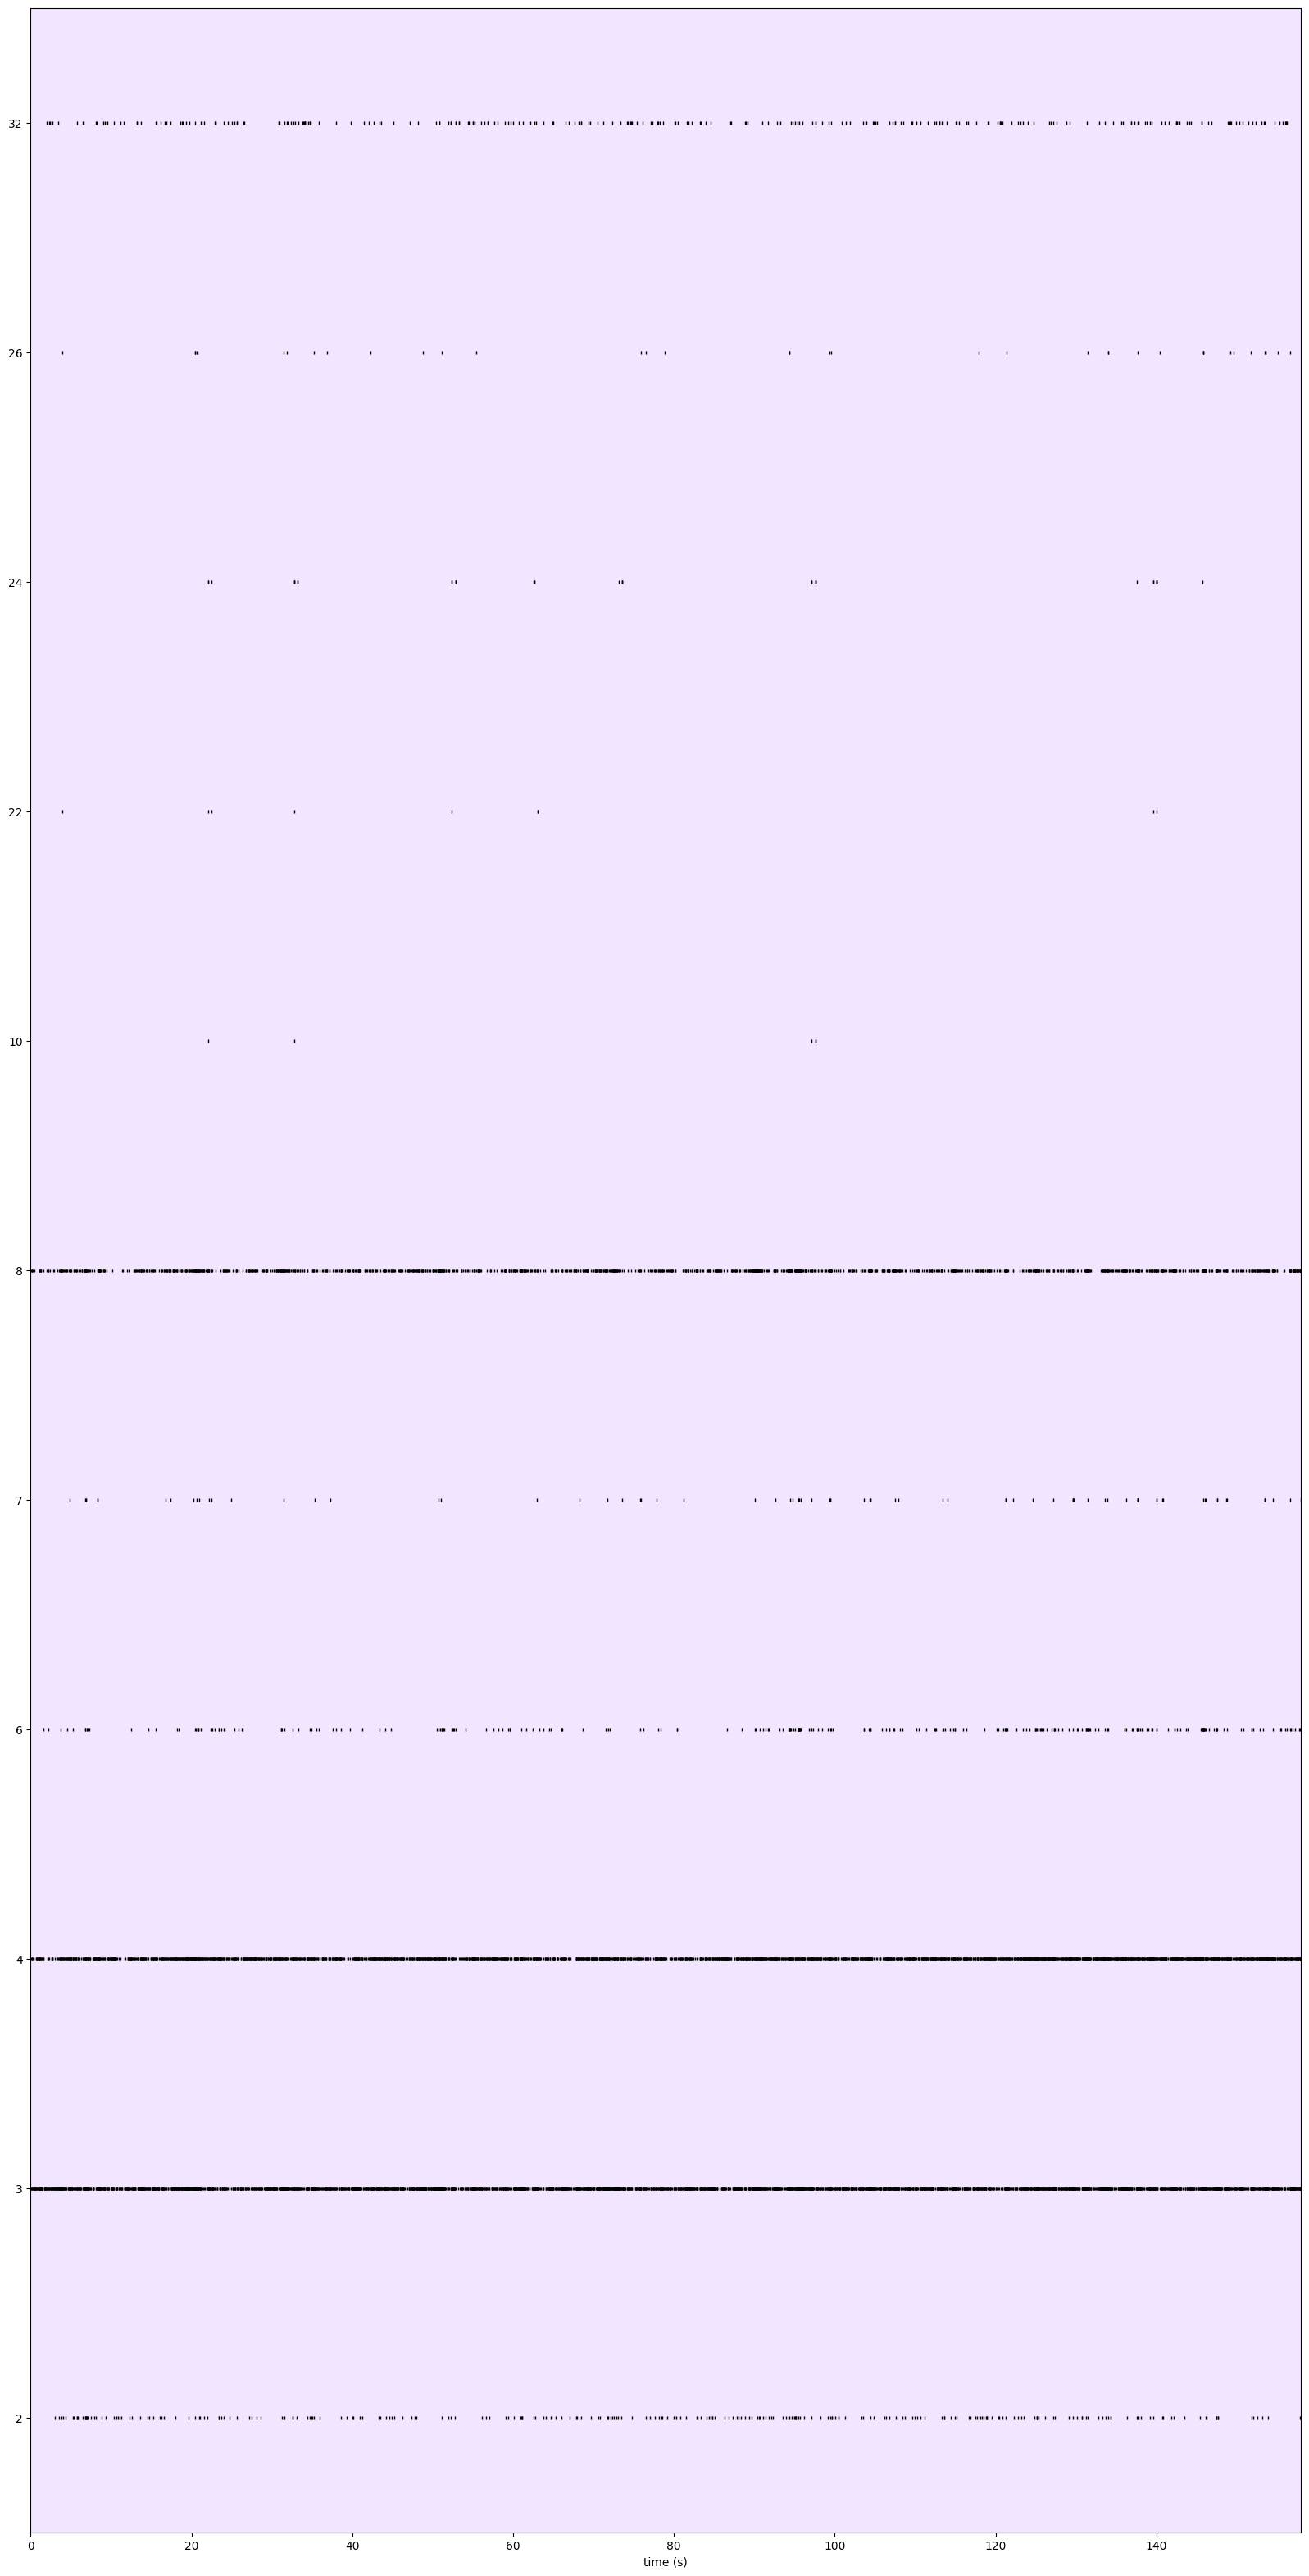

<Figure size 640x480 with 0 Axes>

In [15]:
day_length=[cont_trigger_all_all.shape[0]]
sorting_day_split(sorting, date_id_all, day_length, results_data_path, 
                  sorting_save_name='firings_inlier')

Plot ISI

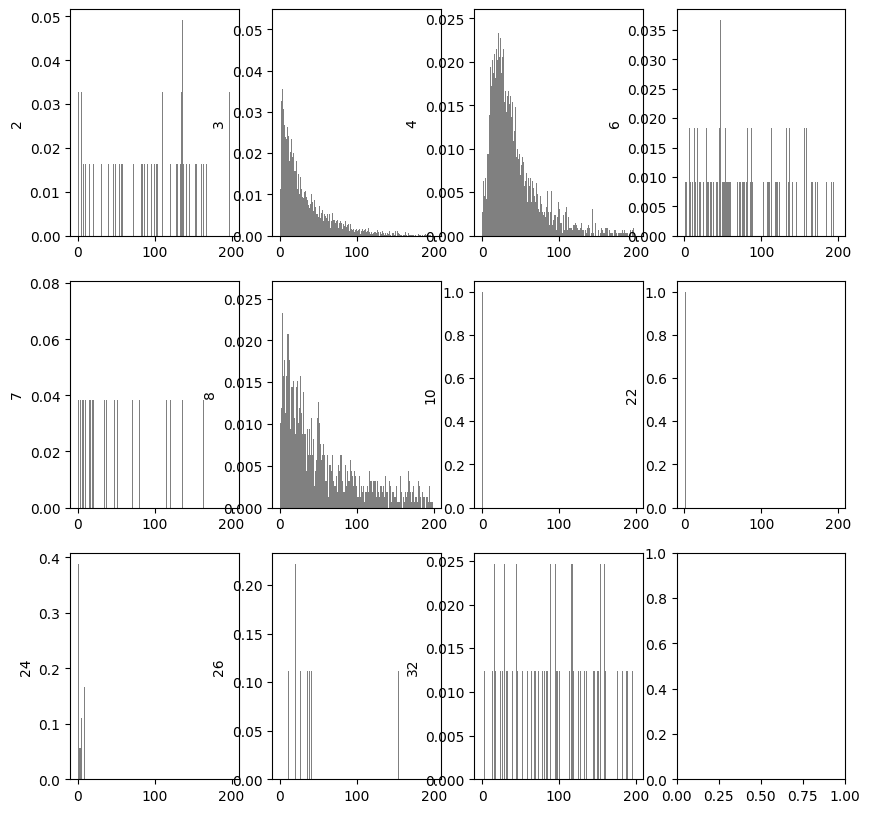

In [16]:
fig,ax = plt.subplots(int(ceil(sorting.unit_ids.shape[0]/4)),4,figsize=(10,10))
sw.plot_isi_distribution(sorting, window_ms=200.0, bin_ms=1.0,axes=ax)

Plot units template

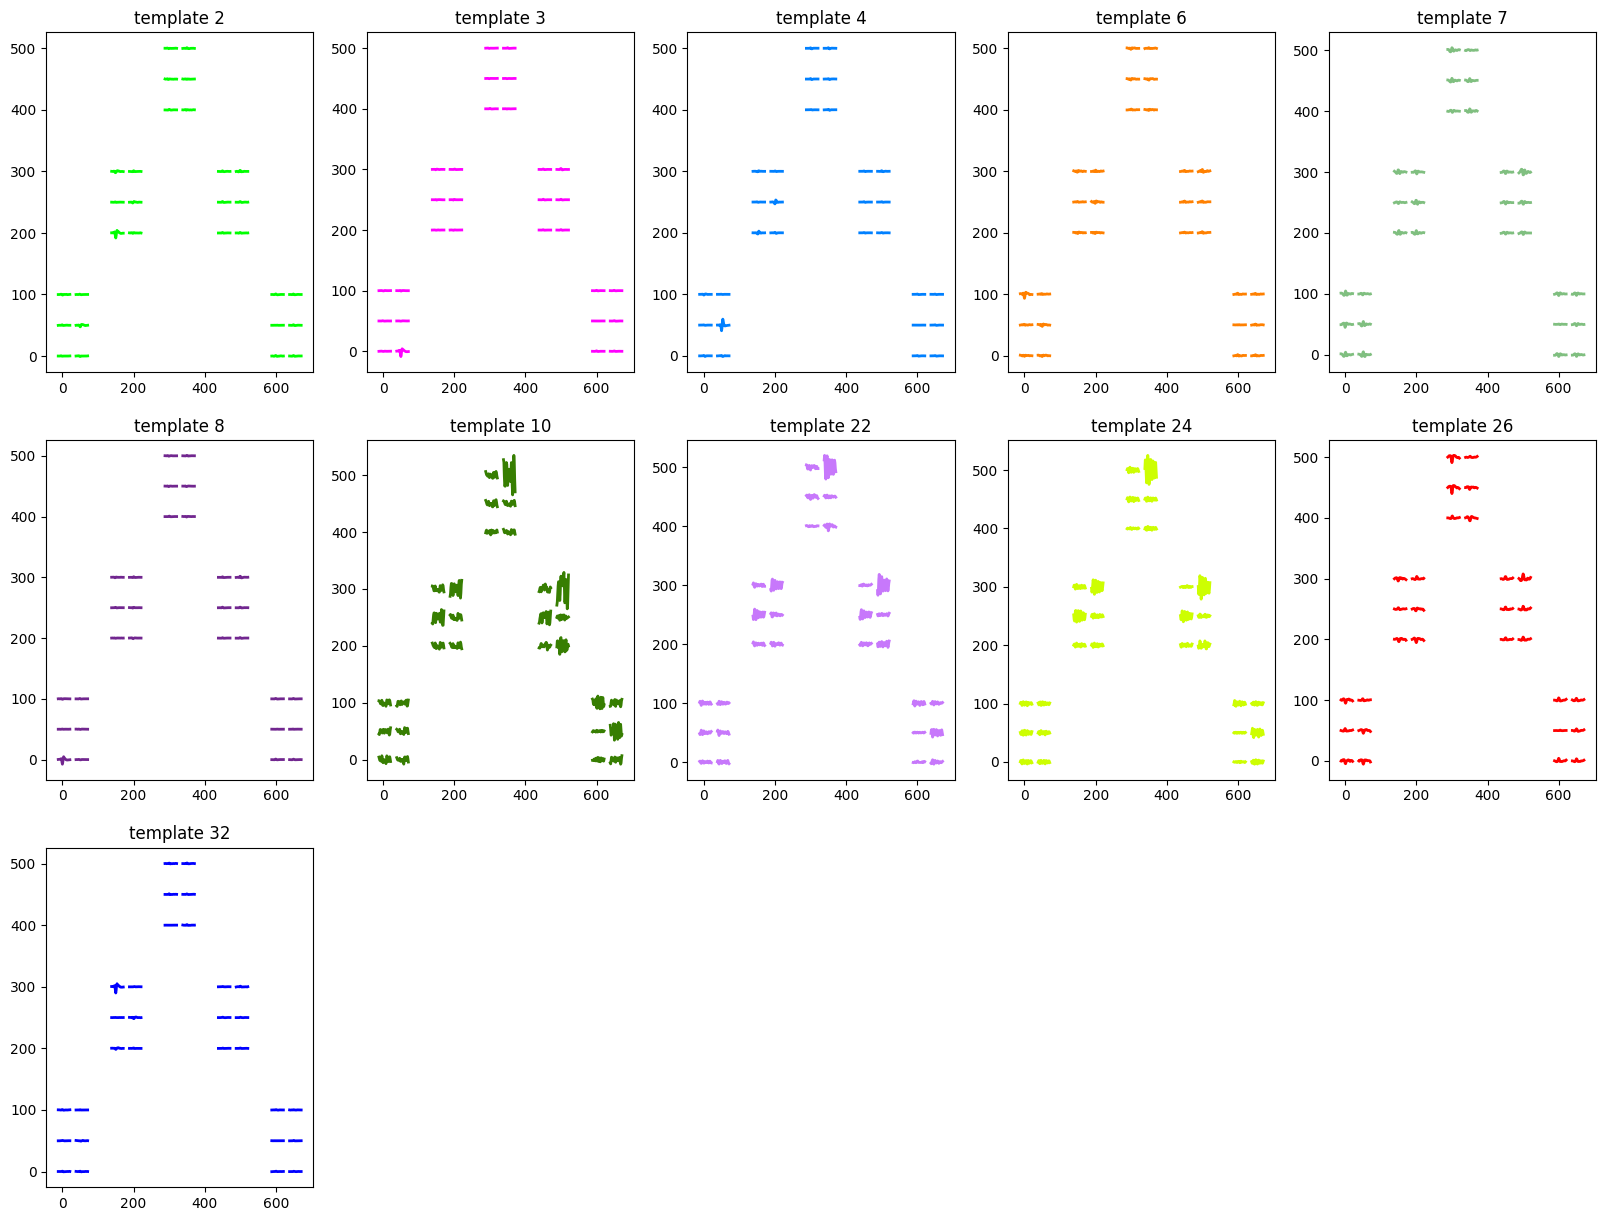

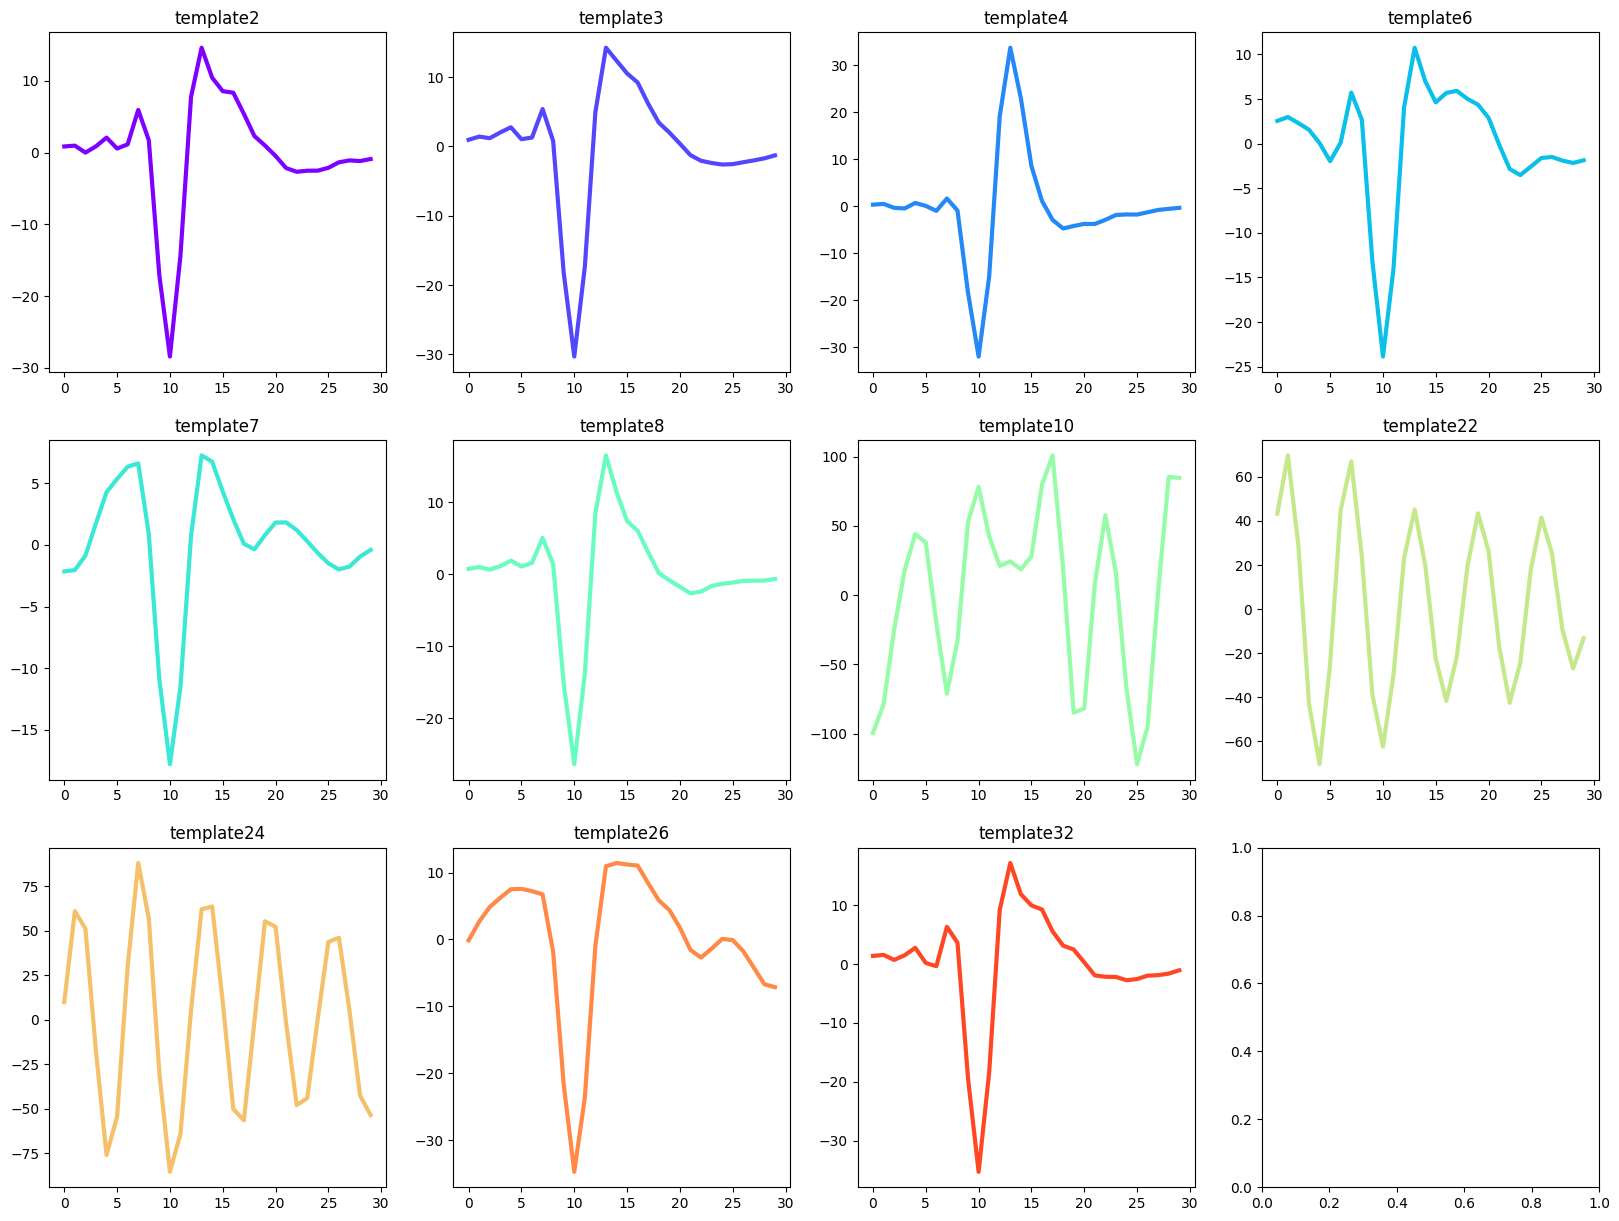

In [17]:
we._template_cache={}
sorting_unit_show(we, recording_cmr, sorting, results_data_path,waveform_folder)